In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import Model
import numpy as np
from keras import optimizers
np.set_printoptions(threshold=np.nan)
from keras.models import load_model

Using TensorFlow backend.


# Load Image

In [3]:
test_filenames = []
for path, subdirs, files in os.walk('data/test/sub_test'):
    for name in files:
        test_filenames.append(os.path.join(path, name))
Base_dir_image = 'data/Augmentation/Train_image/'
Base_dir_mask = 'data/Augmentation/Train_mask/'
Base_dir_vali_image = 'data/validation/image_validation/sub_Image/'
Base_dir_vali_mask = 'data/validation/label_validation/sub_Image/'
img_filenames = glob.glob(Base_dir_image + '*')
mask_filenames = glob.glob(Base_dir_mask + '*')
val_img_filenames = glob.glob(Base_dir_vali_image + '*')
val_mask_filenames = glob.glob(Base_dir_vali_mask + '*')

img_filenames.sort()
mask_filenames.sort()
val_img_filenames.sort()
val_mask_filenames.sort()

print(len(img_filenames))
print(len(mask_filenames))
print(len(val_mask_filenames))
print(len(test_filenames))

186
186
7
44


# Visualization of images and masks

(480, 640, 3)


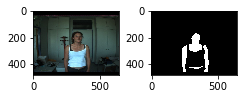

(480, 640, 3)


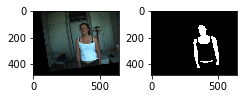

(480, 640, 3)


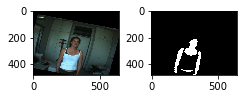

(480, 640, 3)


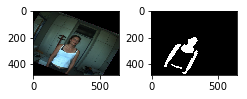

(480, 640, 3)


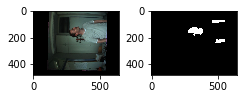

(480, 640, 3)


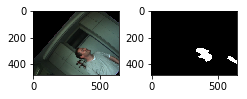

(480, 640, 3)


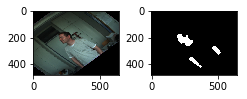

(480, 640, 3)


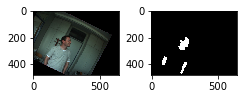

(480, 640, 3)


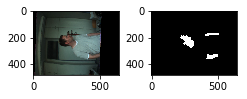

In [4]:
n_examples = 9
for i in range(n_examples):
    plt.subplot(3, 3, 1)
    image = cv2.imread(img_filenames[i])
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    plt.subplot(3, 3, 2)
    mask_file = mask_filenames[i]
    mask = cv2.imread(mask_file)
    ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
    mask = mask[:,:,0]
    plt.imshow((mask), cmap='gray')
    plt.show()

#  External loss function (Dice Function) for training

In [ ]:
def dice_coef(y_true, y_pred, smooth=0.9):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Build net model using keras

In [ ]:
img_rows = 480
img_cols = 640
img_channels = 3

inputs = Input((img_rows, img_cols, img_channels))

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)


conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

opt = Adam()
model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = ['accuracy'])
model.summary()

# Images preprocessing for training

In [ ]:
X = np.ndarray((len(img_filenames), img_rows, img_cols, img_channels), dtype=np.float)
Y = np.ndarray((len(mask_filenames),img_rows, img_cols, 1), dtype=np.float)
Validation_X = np.ndarray((len(val_img_filenames), img_rows, img_cols, img_channels), dtype=np.float)
Validation_Y = np.ndarray((len(val_mask_filenames),img_rows, img_cols, 1), dtype=np.float)

Test_image = np.ndarray((len(test_filenames),img_rows, img_cols, 3), dtype=np.float)
Ix = 0
Iy = 0
Ix_val = 0
Iy_val = 0
It = 0
for image in img_filenames:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array([img/255.])
    X[Ix] = img
    Ix+=1 
for mask in mask_filenames:
    mask = cv2.imread(mask)
    ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
    mask = mask[:,:,0].reshape((480,640,1))
    mask = np.array([mask/255.])
    mask = np.array([mask])
    Y[Iy] = mask
    Iy+=1
    
for image in val_img_filenames:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array([img/255.])
    Validation_X[Ix_val] = img
    Ix_val+=1 
    
for mask in val_mask_filenames:
    mask = cv2.imread(mask)
    ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
    mask = mask[:,:,0].reshape((480,640,1))
    mask = np.array([mask/255.])
    Validation_Y[Iy_val] = mask
    Iy_val+=1

for test in test_filenames:
    test = cv2.imread(test)
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    test = np.array([test/255.])
    Test_image[It] = test
    It+=1

In [ ]:
for i in range(9):
    a = X[i,:,:,:]
    b = Y[i,:,:,0]
    plt.subplot(3, 3, 1)
    plt.imshow((a))
    plt.subplot(3, 3, 2)
    plt.imshow((b))
    plt.show()

# Start training, then save model and process of training

In [ ]:
n_epochs = 50
batch_size = 2
history = model.fit(X, Y, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(Validation_X, Validation_Y), shuffle=True)
model.save('fourth_training.h5')

# Predict and plot training results

In [ ]:
model = load_model('third_training.h5', custom_objects={'dice_coef_loss': dice_coef_loss})
results = model.predict(Test_image, batch_size=2, verbose=1, steps=None)
for i in range(43):
    plt.figure(figsize=(15, 15))
    a = results[i,:,:,0]*255.
    b = Test_image[i,:,:,:]
    plt.subplot(3, 3, 1)
    plt.imshow((a))
    plt.subplot(3, 3, 2)
    plt.imshow((b))
    plt.show()

In [ ]:
results_iamge = []
for i in range(len(results)):
    a = results[i,:,:,0]*255.
    results_iamge.append(a.astype(np.uint8))    

# Morphological Transformations to reduce noise

In [ ]:
img = results_iamge[16]
cv2.imshow("original",img)

kernel_closing = cv2.getStructuringElement(cv2.MORPH_RECT,(11, 11))
kernel_opening = cv2.getStructuringElement(cv2.MORPH_RECT,(11, 11))
kernel_dilated = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3)) 
closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_closing)
cv2.imshow("Close",closed)
opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_closing)
cv2.imshow("opened",opened)
dilated = cv2.dilate(closed,kernel_dilated)
cv2.imshow("dilated", dilated)